## Preparations...

In [2]:
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastai.vision.widgets import *
from fastbook import *

import seaborn as sns

sns.set()

path = untar_data(URLs.PETS)
path_models = Path()
fname = (path/"images").ls()[0]

pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=100, min_scale=0.75))
dls = pets.dataloaders(path/"images")


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


## Learn pretrained model

In [3]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

d:\Projects\PythonProjects\DLS-Rush\venv\lib\site-packages\fastai\vision\learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,2.117838,0.868560,0.248309,04:27
1,1.122211,0.665517,0.205683,03:23
2,0.805833,0.582763,0.184709,02:38


Unfreeze all the layers

In [4]:
learn.unfreeze()

SuggestedLRs(valley=9.120108734350652e-05)

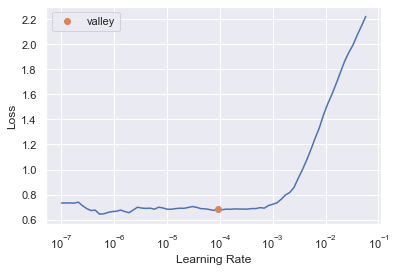

In [5]:
learn.lr_find()

Let’s train at a suitable learning rate:

In [6]:
learn.fit_one_cycle(2, lr_max=1e-5) # There should be 6 epochs here, but I only have a GTX 960...

epoch,train_loss,valid_loss,error_rate,time
0,0.682486,0.562740,0.176590,03:10
1,0.647510,0.559575,0.176590,02:58


## Discriminative learning rates

Let the later layers fine-tune more quickly than earlier layers.

Therefore, fastai’s default approach is to use discriminative learning rates

The first value passed will be the learning rate in the earliest layer of the neural
network, and the second value will be the learning rate in the final layer

In [7]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

learn.fit_one_cycle(3, 3e-3)

learn.unfreeze()

learn.fit_one_cycle(4, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,2.098026,0.789096,0.244926,02:22
1,1.119928,0.643560,0.205007,02:14
2,0.765134,0.596139,0.191475,02:12


epoch,train_loss,valid_loss,error_rate,time
0,0.691341,0.574037,0.187415,03:36
1,0.649479,0.556451,0.180650,02:58
2,0.594800,0.545927,0.171177,02:09
3,0.573203,0.541225,0.169824,01:55


fastai can show us a graph of the training and validation loss:

As you can see, the training loss keeps getting better and better. But notice that
eventually the validation loss improvement slows and sometimes even gets worse!

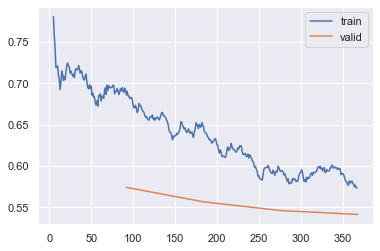

In [10]:
learn.recorder.plot_loss()

One technique that can speed things up a lot is mixed-precision training. This
refers to using less-precise numbers (half-precision floating point, also called fp16)

In [11]:
from fastai.callback.fp16 import *


In [ ]:
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(3, freeze_epochs=3)
